### Time-series prediction með opnum gögnum frá Seðlabanka Íslands 
útfært í Python, Numpy, Pandas og Keras
<br>
<br>
Byrjum á því að fá öll nauðsynleg dependency inn

In [393]:
from urllib import request
import requests
import pandas as pd
import io
from tabulate import tabulate
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from IPython.display import clear_output

### Hérna skilgreinum við hvaða gögn við viljum nota og hvað við viljum spá fyrir um
Nánari upplýsingar hér: http://www.sedlabanki.is/hagtolur/xml-gogn/

In [394]:
# Skilgreina hvaða gögn eru sótt. Við gerum greinarmun á aðalgögnum (gildi sem við ætlum að spá fyrir) og aukagögnum.
data_series = {
    "isk_dkk" : 4061,
    "isk_usd" : 4055,
    "isk_eur" : 4064,
    "isk_gbp" : 4103,
    "isk_yen" : 4085,
    "visitala_neysluverds" : 1,
    "styrivextir1" : 23,
    "daglan" : 24,
    "vidskiptareikn_innl" : 28,
    "styrivextir2" : 55,
    "heildarvelta_innl_gjaldeyris_markadur" : 284,
    "SI_kaup_kr" : 285,
    "SI_sala_kr" : 287,
    "visitala_medalgengis" : 4114,
    "drattarvextir" : 22
}
series_to_predict = "isk_dkk"
series_to_predict_idx = 0

### Næstu tvær sellur fara í að sækja og sameina gögnin

In [395]:
def get_and_append_data(df, series_name, series_id):
    csv = requests.get("http://www.sedlabanki.is/xmltimeseries/Default.aspx?DagsFra=2000-01-01&DagsTil=2018-03-07T23:59:59&TimeSeriesID=" + str(series_id) + "&Type=csv").content
    aux_df = pd.read_csv(io.StringIO(csv.decode('utf-8')), delimiter=';', header=None, names=['0','1','2','3','4','5','time', series_name], parse_dates=['time'])    
    aux_df['time'] = pd.to_datetime(aux_df['time']).dt.date
    aux_df.set_index(aux_df.time, inplace=True)
    aux_df.drop(columns=['0','1','2','3','4','5','time'], inplace=True)
    return pd.concat([df, aux_df], axis=1)       

In [396]:
# Sækja öll viðbótargögn og fylla inn í tóm gildi
csv_df = pd.DataFrame()
for key, value in data_series.items():
    csv_df = get_and_append_data(csv_df, key, value)
csv_df.fillna(method='ffill', inplace=True)    
csv_df.dropna(inplace=True)
csv_df.shape

(4669, 15)

### Skoðum aðeins gögnin sem við ætlum að nota

In [397]:
# Sýna lægstu gildi
csv_df[(csv_df[series_to_predict] == csv_df[series_to_predict].min())]

,isk_dkk,isk_usd,isk_eur,isk_gbp,isk_yen,visitala_neysluverds,styrivextir1,daglan,vidskiptareikn_innl,styrivextir2,heildarvelta_innl_gjaldeyris_markadur,SI_kaup_kr,SI_sala_kr,visitala_medalgengis,drattarvextir
2000-05-04,9.161,76.29,68.25,118.51,0.7012,198.4,10.1,11.0,5.6,9.6,832.68,0.0,0.0,97.0631,21.5


In [398]:
# Sýna hæstu gildi
csv_df[(csv_df[series_to_predict] == csv_df[series_to_predict].max())]

,isk_dkk,isk_usd,isk_eur,isk_gbp,isk_yen,visitala_neysluverds,styrivextir1,daglan,vidskiptareikn_innl,styrivextir2,heildarvelta_innl_gjaldeyris_markadur,SI_kaup_kr,SI_sala_kr,visitala_medalgengis,drattarvextir
2008-12-01,25.103,147.77,187.0,222.26,1.5765,327.9,19.76,20.0,17.5,18.0,334.356,334.356,0.0,234.7999,26.5
2008-12-02,25.103,147.81,187.0,219.01,1.5866,327.9,19.76,20.0,17.5,18.0,2211.275,2211.275,0.0,234.2506,26.5


In [399]:
# Sýna meðaltal
csv_df[series_to_predict].mean()

16.24703748125937

In [400]:
# Sýna miðgildi
csv_df[series_to_predict].median()

16.318

In [401]:
# Geymum afrit af gögnunum eins og þau eru núna áður en við höldum áfram
csv_df_original = csv_df.copy()

### Nú þegar gögnin eru tilbúin fyrir vélanám skiptum við þeim í þjálfunargögn (80%) og prófunargögn (20%)

In [402]:
# Skipta gögnum í þjálfun og prófun
num_train = int(len(csv_df) * 0.8)
num_test = len(csv_df) - num_train
csv_np = csv_df.as_matrix()
training_data, testing_data = csv_np[0:num_train, :], csv_np[num_train:len(csv_df),:]
all_data = csv_np
all_data_dates = csv_df.index.values
## Gerum það sama fyrir dagsetningar vegna myndbirtingar
dates = all_data_dates
training_data_dates, testing_data_dates = dates[0:num_train], dates[num_train:len(dates)]
print('Prófunargögn byrja ' + str(testing_data_dates[0]))

Prófunargögn byrja 2014-07-14


In [403]:
# Normalization
norm_means = []
for i in range(training_data.shape[1]):
    norm_means.append(training_data[:,i].mean())
norm_means = np.array(norm_means)
norm_stddevs = []
for i in range(training_data.shape[1]):
    norm_stddevs.append(training_data[:,i].std())
norm_stddevs = np.array(norm_stddevs)

for i in range(training_data.shape[0]):
    training_data[i] = (training_data[i] - norm_means) / norm_stddevs

for i in range(testing_data.shape[0]):
    testing_data[i] = (testing_data[i] - norm_means) / norm_stddevs

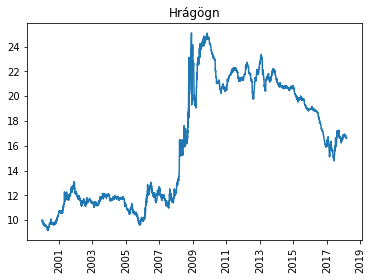

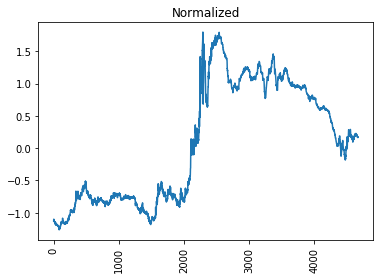

In [404]:
# Visualization

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title('Hrágögn')
plt.xticks(rotation='vertical')
plt.plot(csv_df_original.index, csv_df_original[series_to_predict])

plt.figure()
plt.title('Normalized')
plt.xticks(rotation='vertical')
plt.plot(np.append(training_data[:, 0], testing_data[:, 0]))

### Þetta gæti verið góður tími til að nefna að við ættum kannski að skoða þessi ESB mál aðeins betur...

In [405]:
print("Hlutfallslegur munur á lægsta og hæsta gildi í prósentum: " + str(abs(csv_df_original[series_to_predict].max() / csv_df_original[series_to_predict].min() * 100)))

Hlutfallslegur munur á lægsta og hæsta gildi í prósentum: 274.0203034603209


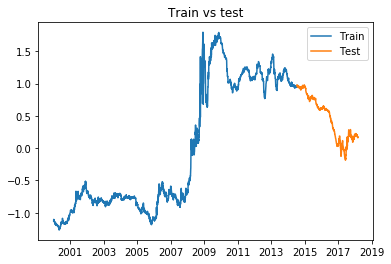

In [406]:
# Hérna sjáum við hvernig gögnin skiptast í þjálfunargögn og prófunargögn
plt.figure()
plt.title('Train vs test')
plt.plot(training_data_dates, training_data[:, series_to_predict_idx], label='Train')
plt.plot(testing_data_dates, testing_data[:, series_to_predict_idx], label='Test')
plt.legend()

### Við ætlum að búa til lítið LSTM spálíkan með Keras.
Til þess þurfum við að huga að nokkrum stillingum:
<br>
<br>
<b>output_lookaheads</b> - Hversu langt fram í tímann (mælt í virkum dögum) gilda spárnar sem við munum búa til. Ef við setjum mörg gildi þarna inn mun netið skapa jafnmargar spár í hverju skrefi. Til dæmis ef output_lookaheads = [3, 7] þá mun hvert spákref skila bæði spáum sem gilda 3 og 7 virka daga fram í tímann.
<br>
<br>
<b>seq_length</b> - Hvað byggir hvert spáskref á mörgum fyrri tímaskrefum (virkum dögum).
<br>
<br>
<b>hidden_layers</b> - Hversu mörg og hversu stór lög af LSTM taugungum ætlum við að nota




In [417]:
# Stillingar
output_lookaheads = [14]
seq_length = 10
hidden_layers = [16, 16]

### Forvinnsla á gögnum í næstu tveimur sellum

In [418]:
# Útbúa gögn
def make_data_and_labels(data, lookaheads):
    i, j = 0, seq_length
    inputs, outputs = [], []
    maxlookahead = lookaheads[-1]
    while j + maxlookahead < len(data):
        input_data = data[i:j, :]
        output_data = []
        for lh in lookaheads:
            output_data.append(data[j+lh, series_to_predict_idx])
        inputs.append(input_data)
        outputs.append(output_data)
        i += 1
        j += 1        
    return np.array(inputs), np.array(outputs)

In [419]:
inputs_train, outputs_train = make_data_and_labels(training_data, output_lookaheads)
inputs_train = np.reshape(inputs_train, (inputs_train.shape[0], inputs_train.shape[2], inputs_train.shape[1]))

inputs_test, outputs_test = make_data_and_labels(testing_data, output_lookaheads)
inputs_test = np.reshape(inputs_test, (inputs_test.shape[0], inputs_test.shape[2], inputs_test.shape[1]))

inputs_all, outputs_all = make_data_and_labels(all_data, output_lookaheads)
inputs_all = np.reshape(inputs_all, (inputs_all.shape[0], inputs_all.shape[2], inputs_all.shape[1]))

In [420]:
# Kóði sem hjálpar okkur að sjá myndrænt hvernig þjálfunin gengur
# Fengið héðan: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    
    def __init__(self):
        self.cnt = 0
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        if self.cnt % 10 == 0:
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.i += 1

            clear_output(wait=True)
            plt.plot(self.x, self.losses, label="loss")
            plt.plot(self.x, self.val_losses, label="val_loss")
            plt.legend()
            plt.show()
        self.cnt += 1
        
plot_losses = PlotLosses()

### Nú fer þjálfunin af stað. Það gæti mögulega þurft að aðlaga batch_size eða þolinmæði að ykkar aðstæðum ef þið viljið keyra kóðann sjálf. Þjálfunin tekur minna en tvær mínútur á GTX 1080.

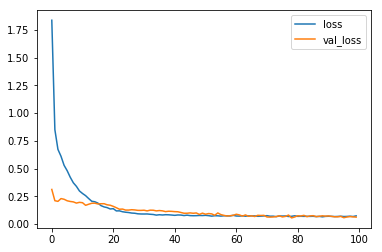

Epoch 992/1000
3711/3711 [==============================] - 0s 30us/step - loss: 0.0665 - acc: 0.0000e+00 - val_loss: 0.0612 - val_acc: 0.0000e+00
Epoch 993/1000
3711/3711 [==============================] - 0s 24us/step - loss: 0.0687 - acc: 0.0000e+00 - val_loss: 0.0608 - val_acc: 0.0000e+00
Epoch 994/1000
3711/3711 [==============================] - 0s 29us/step - loss: 0.0687 - acc: 0.0000e+00 - val_loss: 0.0625 - val_acc: 0.0000e+00
Epoch 995/1000
3711/3711 [==============================] - 0s 27us/step - loss: 0.0678 - acc: 0.0000e+00 - val_loss: 0.0651 - val_acc: 0.0000e+00
Epoch 996/1000
3711/3711 [==============================] - 0s 25us/step - loss: 0.0667 - acc: 0.0000e+00 - val_loss: 0.0673 - val_acc: 0.0000e+00
Epoch 997/1000
3711/3711 [==============================] - 0s 32us/step - loss: 0.0667 - acc: 0.0000e+00 - val_loss: 0.0665 - val_acc: 0.0000e+00
Epoch 998/1000
3711/3711 [==============================] - 0s 26us/step - loss: 0.0680 - acc: 0.0000e+00 - val_loss: 

In [421]:
# Búa til og þjálfa LSTM net með Keras
model = Sequential()
for i in range(len(hidden_layers)):    
    if i == 0:
        model.add(LSTM(hidden_layers[i], input_shape=(len(data_series),seq_length), return_sequences=(not i == len(hidden_layers)-1)))
    else:
        model.add(LSTM(hidden_layers[i], return_sequences=(not i == len(hidden_layers)-1)))            
    model.add(Dropout(0.5))
    model.add(BatchNormalization())    
    
model.add(Dense(len(output_lookaheads), activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(inputs_train, outputs_train, epochs=1000, batch_size=2048, validation_data=(inputs_test, outputs_test), 
          callbacks=[plot_losses])


### Könnum hvernig þetta gekk

In [422]:
def unpack_outputs(outputs):
    result = []
    for l in range(len(output_lookaheads)):
        result.append(outputs[:,l])
    return np.array(result)

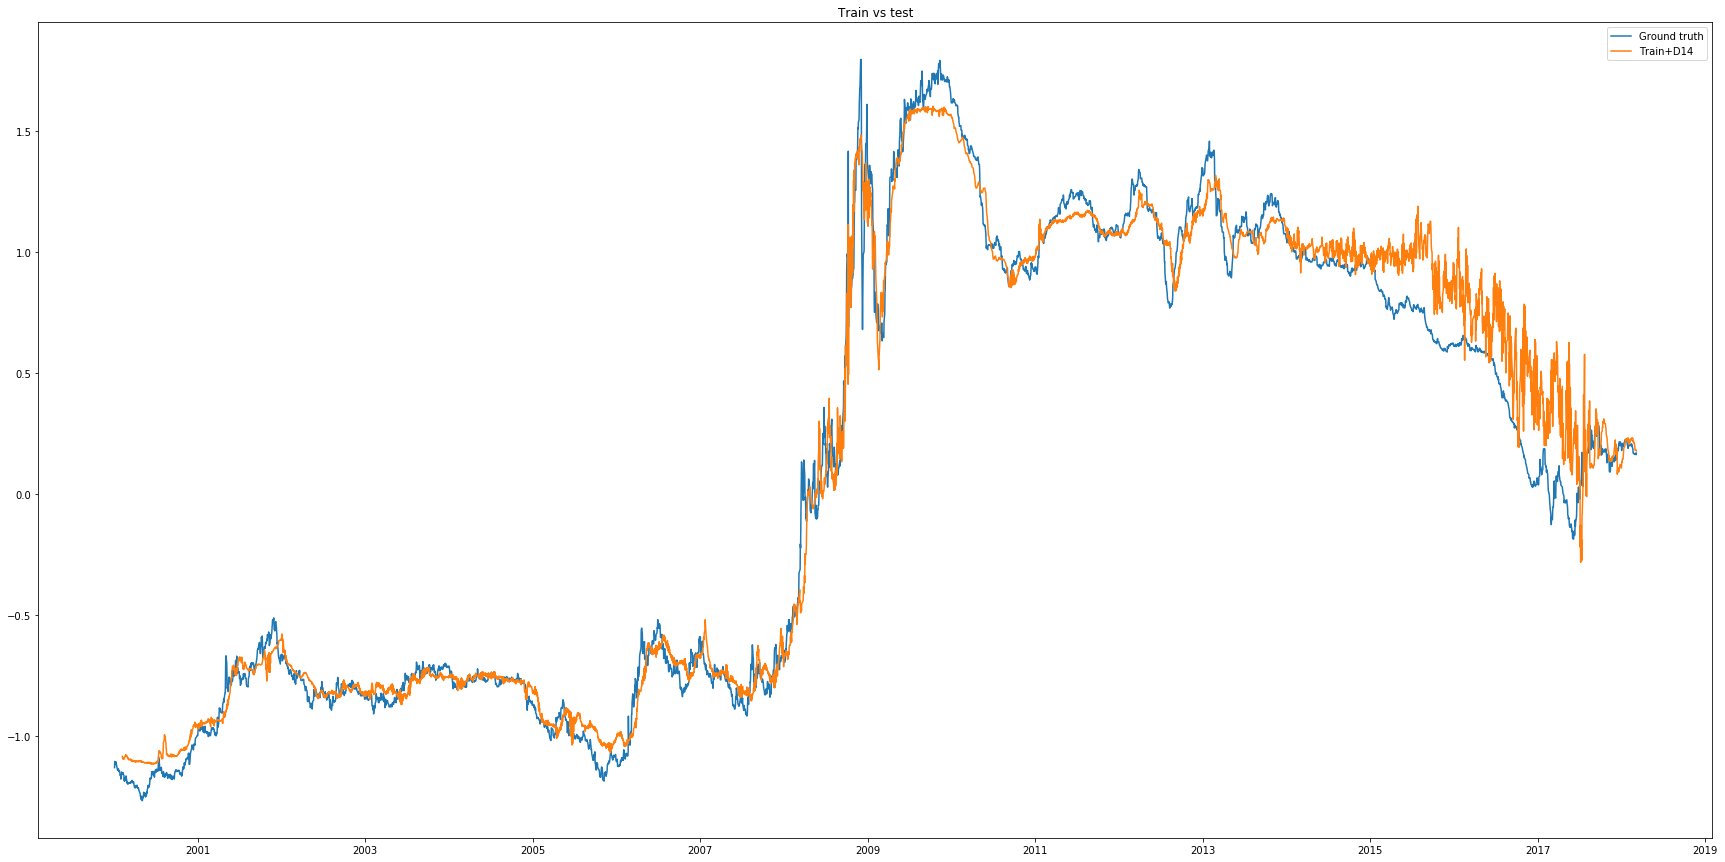

In [423]:
predictions_all = model.predict(inputs_all, batch_size=None, verbose=0, steps=None)
predictions_all = unpack_outputs(predictions_all)
plt.figure(figsize=(30, 15))
plt.title('Train vs test')
plt.plot(all_data_dates, all_data[:,0], label='Ground truth')
plt.plot(all_data_dates[seq_length+max(output_lookaheads):], predictions_all[0], label='Train+D14')
plt.legend()

#### Takið eftir að hvert spágildi er teiknað inn á þann dag sem spáin á við, en spágildið er framleitt 14 virkum dögum fyrr 
(eða eftir því sem output_lookaheads er stillt)
<br>

© Helgi Páll Helgason 2018
<br>
Kóðinn er ætlaður til fræðslu, engin ábyrgð er tekin á notkun hans.
<br>
Öll gögn notuð hér eru sótt beint frá Seðlabanka Íslands á keyrslutíma.
